## Job Search

#### John Stachurski

This notebook solves a McCall style job search model with persistent and transitory components to wages.  Dynamic programming is accelerated by JIT compilation using Numba, as well as shared-memory parallelization via `prange`.

Wages at each point in time are given by

$$    w = \exp(z) + y $$

$$    y \sim \exp(μ + s ζ)  $$

$$    z' = d + ρ z + σ ε $$

with ζ and ε both iid and N(0, 1).   

The worker can either

* accept an offer and work permanently at that wage, or
* take unemployment compensation $c$ and wait till next period

The value function satisfies the Bellman equation

$$ v^*(w, z) = \max \left\{ \frac{u(w)}{1-β}, u(c) + β \, \mathbb E_z v^*(w', z') \right\} $$

There's a way that we can reduce dimension in this problem, which massively accelerates compution.

To see this, let $f^*$ be the continuation value function, defined by

$$ f^*(z) := u(c) + β \, \mathbb E_z v^*(w', z') $$

The Bellman equation can now be written

$$ v^*(w, z) = \max \left\{ \frac{u(w)}{1-β}, \, f^*(z) \right\} $$

Combining the last two expressions, we see that the continuation value function satisfies

$$    f^*(z) = u(c) + β \, \mathbb E_z \max \left\{ \frac{u(w')}{1-β}, f^*(z') \right\} $$

We'll solve this functional equation for $f^*$ by introducing the operator

$$    Qf(z) = u(c) + β \, \mathbb E_z \max \left\{ \frac{u(w')}{1-β}, f(z') \right\} $$


By construction, $f^*$ is a fixed point of $Q$

It turns out that $Q$ is a contraction map, so $f^*$ is the unique fixed point and we can calculate it by iteration

Once we have $f^*$, we can solve the search problem by stopping when the reward for excepting exceeds the continuation value, or

$$    \frac{u(w)}{1-β} \geq f^*(z) $$

For utility we take $u(c) = \ln(c)$.  The reservation wage is the wage where
equality holds in the last expression.

That is,

$$    w^*(z) = \exp(f^*(z) (1-β)) $$

One of our key aims is to solve for the reservation rule. 

When we iterate, f is stored as a vector of values on a grid and these points
are interpolated into a function as necessary.

Interpolation is piecewise linear.

The integral in the definition of $Qf$ is calculated by Monte Carlo.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from lininterp import interp1d
from numba import jit, njit, prange


In [4]:
class JobSearch:

    def __init__(self,
                 μ=0.0,    # transient shock log mean
                 s=1.0,    # transient shock log variance
                 d=0.0,    # shift coefficient of persistent state
                 ρ=0.9,    # correlation coefficient of persistent state
                 σ=0.1,    # state volatility
                 β=0.98,   # discount factor
                 c=5,      # unemployment compensation
                 mc_size=2000,
                 grid_size=200):

        self.μ, self.s, self.d,  = μ, s, d, 
        self.ρ, self.σ, self.β, self.c = ρ, σ, β, c 

        # Set up grid
        z_mean = d / (1 - ρ)
        z_sd = np.sqrt(σ / (1 - ρ**2))
        k = 3  # std devs from mean
        a, b = z_mean - k * z_sd, z_mean + k * z_sd
        self.z_grid = np.linspace(a, b, grid_size)

        # Store shocks
        self.mc_size = mc_size
        self.e_draws = randn(2, mc_size)

    def parameters(self):
        """
        Return all parameters as a tuple.
        """
        return self.μ, self.s, self.d, \
                self.ρ, self.σ, self.β, self.c
        

In [5]:
def generate_Q_operator(js, parallel_flag=True):
    """
    Build an efficient Q operator and return it.
    """
    μ, s, d, ρ, σ, β, c = js.parameters()
    e_draws = js.e_draws
    z_grid = js.z_grid
    M = e_draws.shape[1]

    @njit(parallel=parallel_flag)
    def Q(f_in, f_out):       
        for i in prange(len(z_grid)):
            z = z_grid[i]
            expectation = 0.0
            for m in range(M):
                e1, e2 = e_draws[:, m]
                z_next = d + ρ * z + σ * e1
                go_val = interp1d(z_grid, f_in, z_next) # f(z') 
                y_next = np.exp(μ + s * e2)             # y' draw
                w_next = np.exp(z_next) + y_next        # w' draw
                stop_val = np.log(w_next) / (1 - β)    
                expectation += max(stop_val, go_val)
            expectation = expectation / M 
            f_out[i] = np.log(c) + β * expectation
    return Q

In [12]:
def compute_fixed_point(js,
                        f_init,
                        use_parallel=True,
                        tol=1e-4, 
                        max_iter=1000, 
                        verbose=True,
                        print_skip=25): 

    f_out = np.empty_like(f_init)
    Q = generate_Q_operator(js, parallel_flag=use_parallel)

    # Set up loop
    f_in = f_init
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        Q(f_in, f_out)
        error = np.max(np.abs(f_in - f_out))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        f_in[:] = f_out

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return f_out

In [13]:
js = JobSearch()
f_init = np.log(js.c) * np.ones(len(js.z_grid))

In [14]:
%%time

f_star = compute_fixed_point(js, f_init, use_parallel=False, verbose=True)


Error at iteration 25 is 0.6251635670456039.
Error at iteration 50 is 0.1246255804955041.
Error at iteration 75 is 0.03140597145703339.
Error at iteration 100 is 0.008376343447679346.
Error at iteration 125 is 0.0022672208568792485.
Error at iteration 150 is 0.0006161901762880007.
Error at iteration 175 is 0.000167808343633169.

Converged in 185 iterations.
CPU times: user 37.2 s, sys: 12 ms, total: 37.2 s
Wall time: 37.1 s


In [15]:
f_init = np.log(js.c) * np.ones(len(js.z_grid))

In [16]:
f_star = compute_fixed_point(js, f_init, use_parallel=True, verbose=True)

Error at iteration 25 is 0.6251635670456039.
Error at iteration 50 is 0.1246255804955041.
Error at iteration 75 is 0.03140597145703339.
Error at iteration 100 is 0.008376343447679346.
Error at iteration 125 is 0.0022672208568792485.
Error at iteration 150 is 0.0006161901762880007.
Error at iteration 175 is 0.000167808343633169.

Converged in 185 iterations.


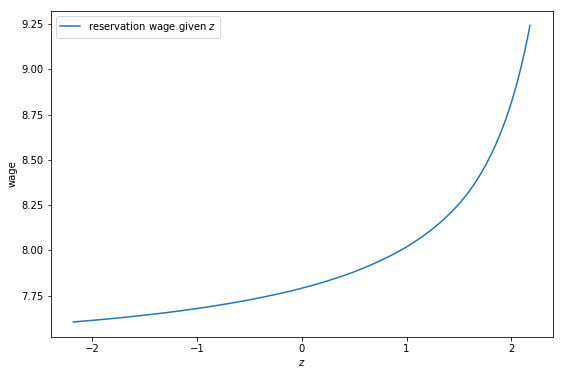

In [17]:
res_wage_function = np.exp(f_star * (1 - js.β))

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(js.z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

### Let's try changing unemployment compensation

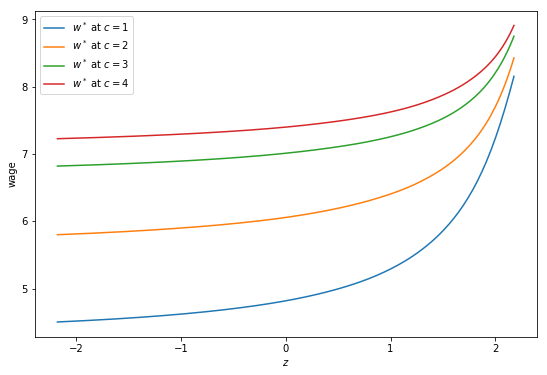

In [18]:
c_vals = 1, 2, 3, 4

fig, ax = plt.subplots(figsize=(9, 6))

for c in c_vals:
    js = JobSearch(c=c)
    f_star = compute_fixed_point(js, f_init, verbose=False)
    res_wage_function = np.exp(f_star * (1 - js.β))
    ax.plot(js.z_grid, res_wage_function, label=f"$w^*$ at $c = {c}$")
    
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

### Exercise: Unemployment Duration

Let's study how mean unemployment duration varies with unemployment compensation.

For simplicity we'll fix the initial state at $z_t = 0$.

In [19]:
def compute_unemployment_duration(js, seed=1234):
    
    f_star = compute_fixed_point(js, f_init, verbose=False)
    μ, s, d, ρ, σ, β, c = js.parameters()
    z_grid = js.z_grid
    np.random.seed(seed)
        
    @njit
    def f_star_function(z):
        return interp1d(z_grid, f_star, z)

    @njit
    def draw_tau(t_max=10_000):
        z = 0
        t = 0

        unemployed = True
        while unemployed and t < t_max:
            # draw current wage
            y = np.exp(μ + s * np.random.randn())
            w = np.exp(z) + y
            res_wage = np.exp(f_star_function(z) * (1 - β))
            # if optimal to stop, record t
            if w >= res_wage:
                unemployed = False
                τ = t
            # else increment data and state 
            else:
                z = ρ * z + d + σ * np.random.randn()
                t += 1
        return τ

    @njit(parallel=True)
    def compute_expected_tau(num_reps=100_000):
        sum_value = 0
        for i in prange(num_reps):
            sum_value += draw_tau()
        return sum_value / num_reps

    return compute_expected_tau()
        

In [20]:
c_vals = np.linspace(1.0, 10.0, 8)
durations = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    js = JobSearch(c=c)
    τ = compute_unemployment_duration(js)
    durations[i] = τ
    
    

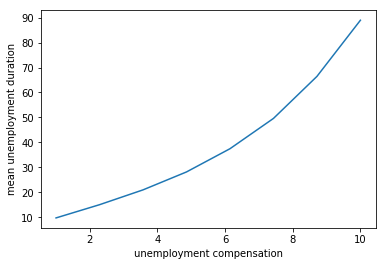

In [21]:
fig, ax = plt.subplots()
ax.plot(c_vals, durations)
ax.set_xlabel("unemployment compensation")
ax.set_ylabel("mean unemployment duration")
plt.show()

### Exercise

Investigate how mean unemployment duration varies with the discount factor $\beta$.  What is your prior?  Do your results match up?

In [22]:
for i in range(40):
    print("solution below!")

solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!


### Solution

Here's one solution.  It shows, not surprisingly, that more patient individuals tend to wait longer before accepting an offer.

In [23]:
beta_vals = np.linspace(0.94, 0.99, 10)
durations = np.empty_like(beta_vals)
for i, β in enumerate(beta_vals):
    js = JobSearch(β=β)
    τ = compute_unemployment_duration(js)
    durations[i] = τ
    
    

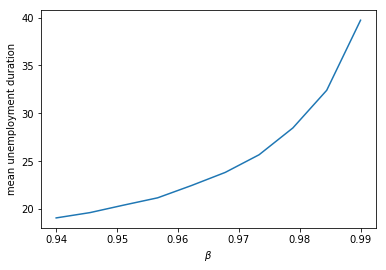

In [24]:
fig, ax = plt.subplots()
ax.plot(beta_vals, durations)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("mean unemployment duration")
plt.show()